In [50]:
library(ggplot2)
library(reshape2)
library(plyr)
library(dplyr)
library(rpart)
library(rpart.plot)
library(caret)
library(doMC)
library(scales)
library(GGally)

set.seed(42)
theme_set(theme_minimal())
registerDoMC(cores = 8)
options(warn=-1)

In [2]:
source("utils.R")

# Step 1: Load & preprocess data

In [3]:
df <- read.csv("data/kc_house_data.csv", stringsAsFactors = FALSE)

In [4]:
print(paste("rows:", nrow(df), "cols:", ncol(df)))

[1] "rows: 21613 cols: 21"


In [5]:
# remove date & id
df <- df[-c(1, 2)]
df$condition <- as.factor(df$condition)
df$view <- as.factor(df$view)
df$grade <- as.factor(df$grade)
df$waterfront <- as.factor(df$waterfront)

In [6]:
head(df)

price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
221900,3,1.00,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
538000,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
180000,2,1.00,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
604000,4,3.00,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
510000,3,2.00,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
1225000,4,4.50,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


# Step 2: Explore

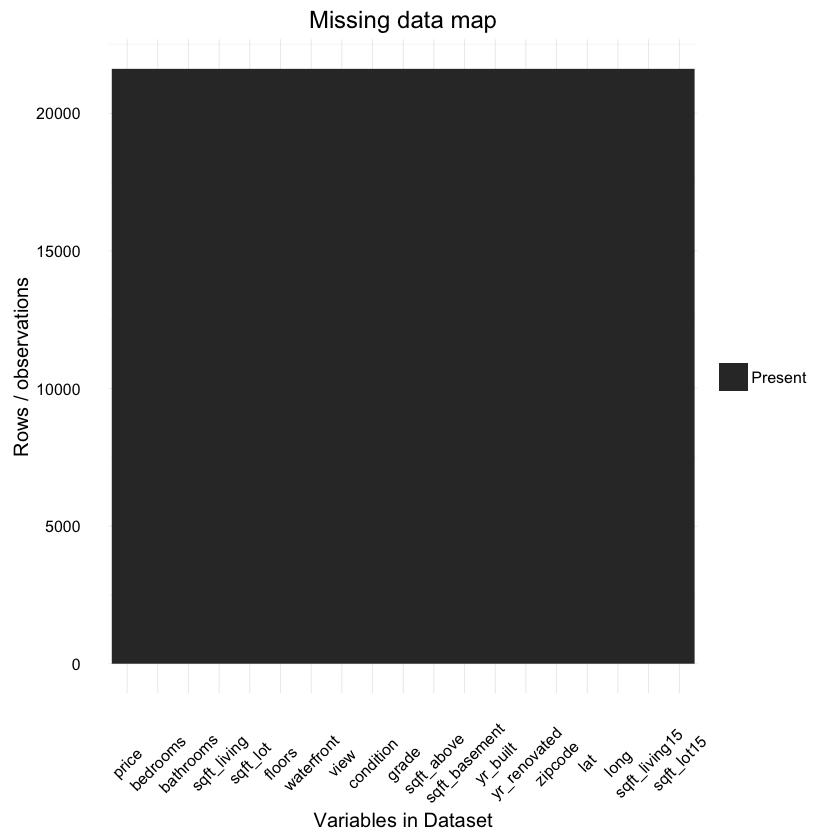

In [7]:
ggplot_missing(df)

## Maps

[Where houses are located?](https://harlfoxem.github.io/houses.html) <br/>
[Number of houses by zipcode](https://harlfoxem.github.io/count.html) <br/>
[Price by zipcode](https://harlfoxem.github.io/price.html)

In [8]:
p1 <- qplot(condition, data=df, geom = "bar", main="Number of houses by condition")

In [9]:
p2 <- qplot(grade, data=df, geom = "bar", main="Number of houses by grade")

In [10]:
p3 <- ggplot(df, aes(price)) + geom_density() + 
    scale_y_continuous(labels = comma) +
    scale_x_continuous(labels = comma, limits = c(0, 2e+06)) +
    xlab("price") +
    ggtitle("Price distribution")

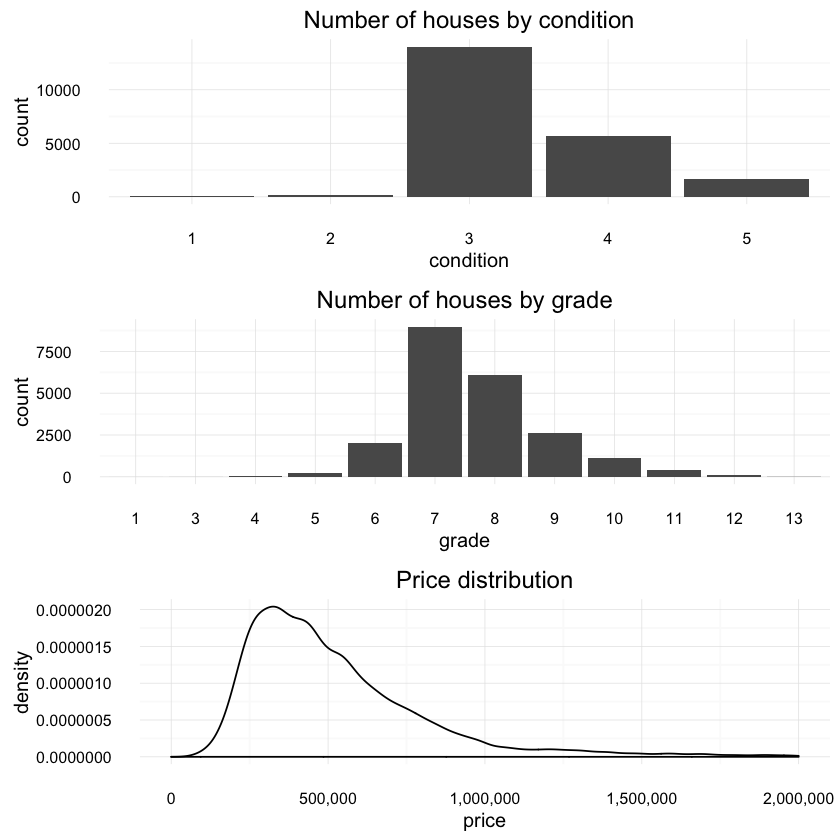

In [11]:
multiplot(p1, p2, p3)

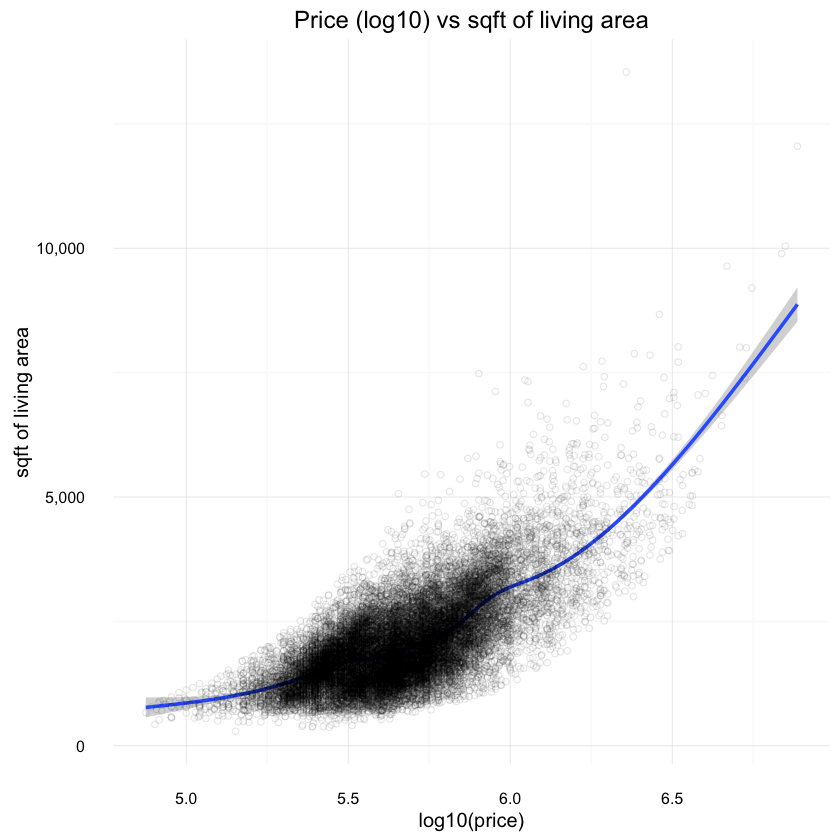

In [47]:
ggplot(df, aes(x=log10(price), y=sqft_living)) +
    geom_smooth() +
    scale_y_continuous(labels = comma) +
    scale_x_continuous(labels = comma) +
    ylab("sqft of living area") + 
    geom_point(shape=1, alpha=1/10) +
    ggtitle("Price (log10) vs sqft of living area")

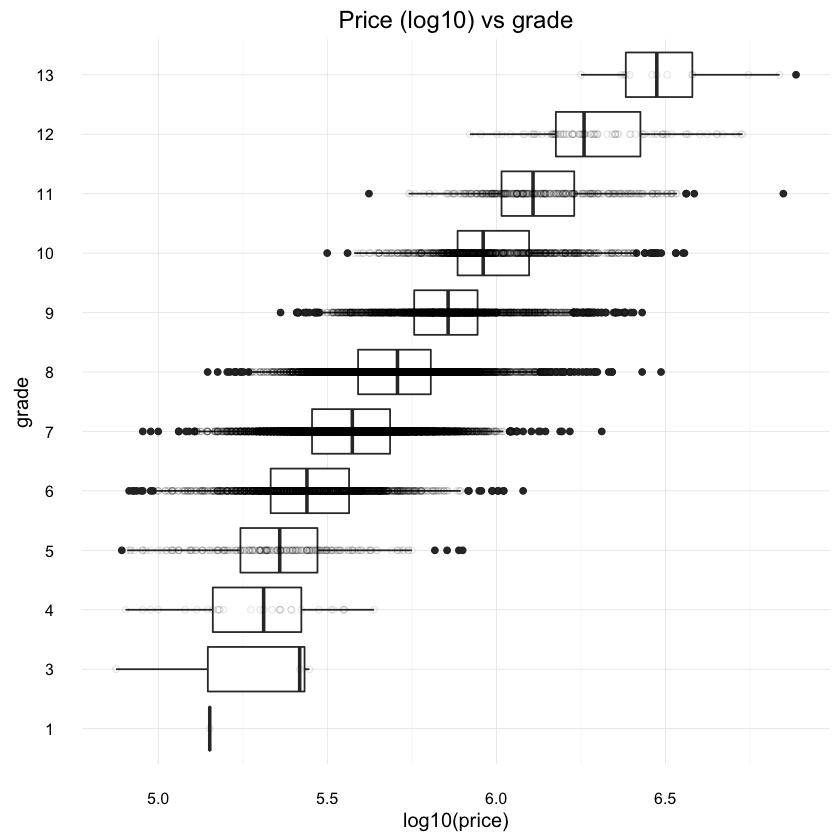

In [13]:
ggplot(df, aes(x=grade, y=log10(price))) +
    geom_boxplot() +
    scale_y_continuous(labels = comma) +
    coord_flip() +
    geom_point(shape=1, alpha=1/10) +
    ggtitle("Price (log10) vs grade")

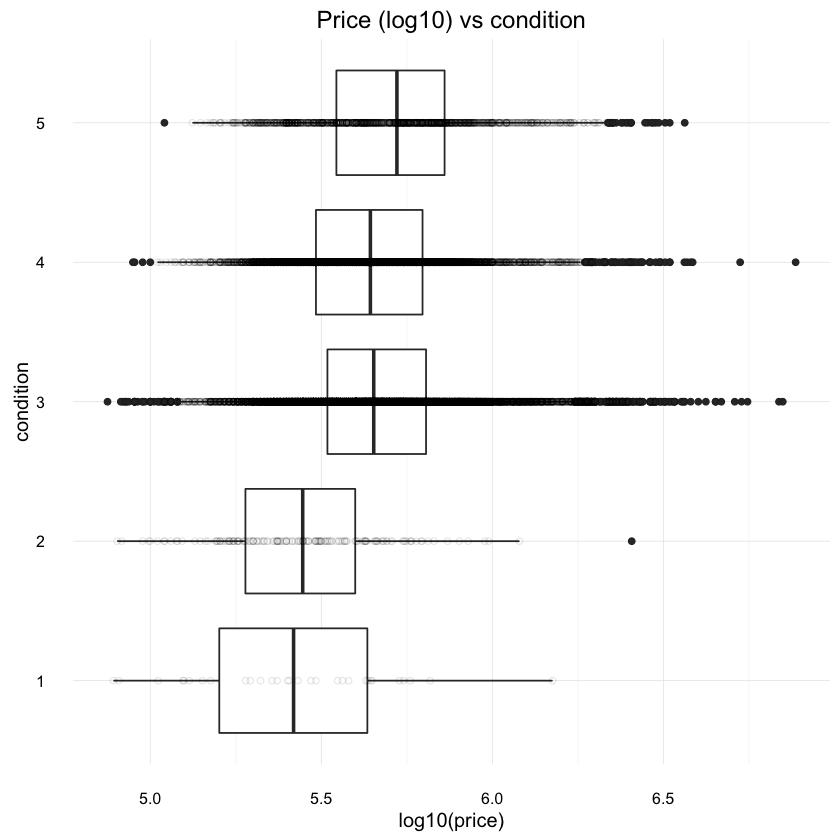

In [14]:
ggplot(df, aes(x=condition, y=log10(price))) +
    geom_boxplot() +
    scale_y_continuous(labels = comma) +
    coord_flip() +
    geom_point(shape=1, alpha=1/10) +
    ggtitle("Price (log10) vs condition")

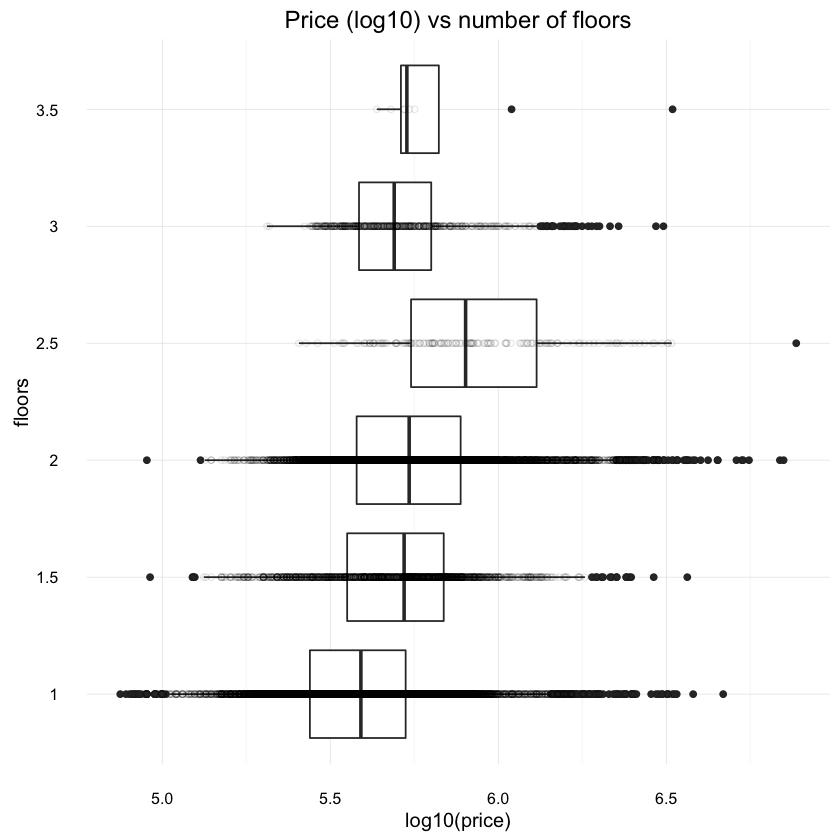

In [46]:
ggplot(df, aes(x=as.factor(floors), y=log10(price))) +
    geom_boxplot() +
    scale_y_continuous(labels = comma) +
    xlab("floors") +
    coord_flip() +
    geom_point(shape=1, alpha=1/10) +
    ggtitle("Price (log10) vs number of floors")

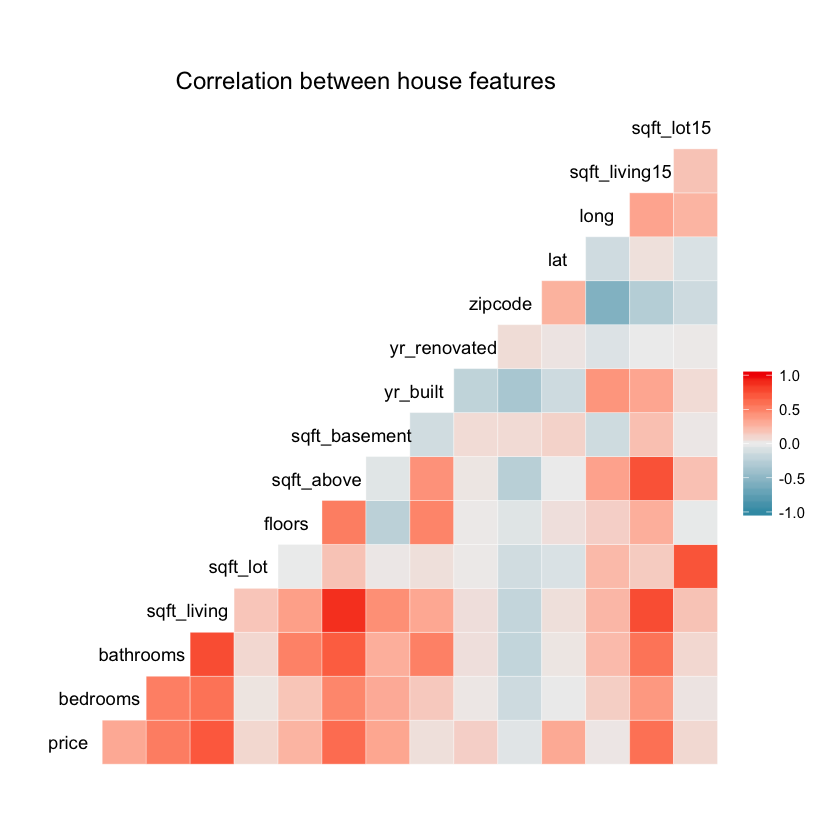

In [49]:
ggcorr(df, hjust = 0.8, layout.exp = 1) + 
    ggtitle("Correlation between house features")

# Step 3: Split the data

Split to 90% training, 10% testing

In [17]:
train_idx = createDataPartition(df$price, p=.9, list=FALSE)

train <- df[train_idx, ]
test <- df[-train_idx, ]

In [18]:
test_labels <- test[, 1]

# Step 4: Fit a decision tree model

Use all features to train decision tree model

In [19]:
tree_fit <- rpart(price ~ ., data=df)

In [20]:
tree_predicted <- predict(tree_fit, test)

In [21]:
summary(tree_predicted)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 315400  315400  462800  542000  654900 5081000 

In [22]:
summary(test_labels)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  82000  322100  450000  536300  643900 3419000 

In [23]:
cor(tree_predicted, test_labels)

[1] 0.8145749

In [24]:
rmse(tree_predicted, test_labels)

[1] 197634.3

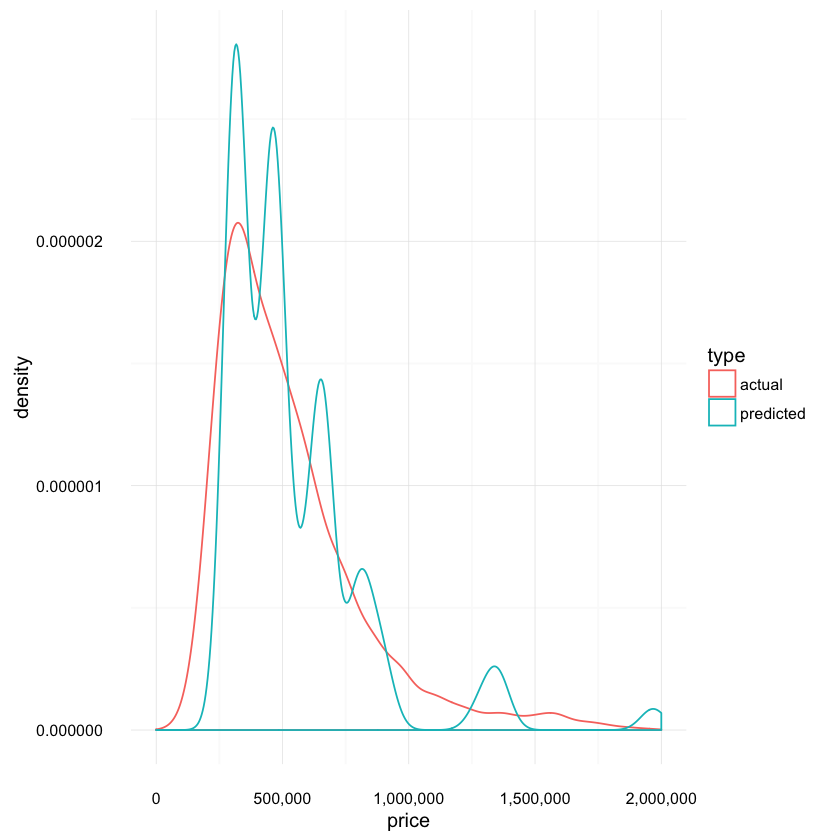

In [25]:
res <- data.frame(price=c(tree_predicted, test_labels), 
                  type=c(replicate(length(tree_predicted), "predicted"), replicate(length(test_labels), "actual")))

ggplot(res, aes(x=price, colour=type)) +
    scale_x_continuous(labels = comma, limits = c(0, 2e+06)) +
    scale_y_continuous(labels = comma) +
    geom_density()

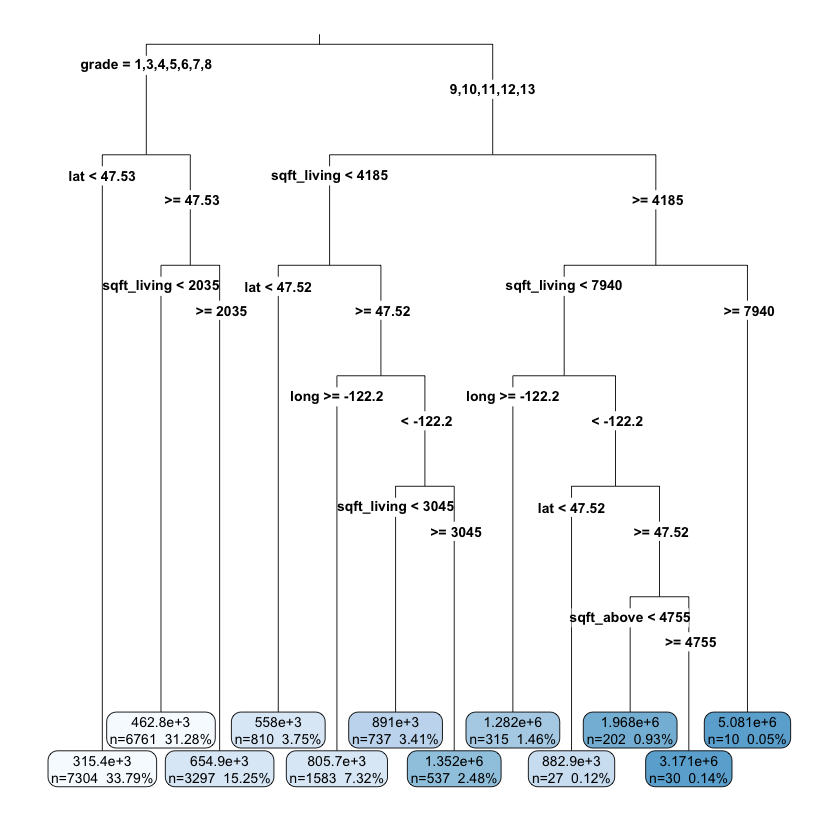

In [26]:
rpart.plot(tree_fit, digits = 4, fallen.leaves = TRUE,
             type = 3, extra = 101)

# Step 4: Fit a xgbTree tree model

Can we do better? Enter `caret`.

In [27]:
ctrl = trainControl(method="cv", number=10, allowParallel = TRUE)

In [28]:
# param_grid <-  expand.grid(eta = c(0.3, 0.5, 0.8), 
#                         max_depth = c(4:10), 
#                         gamma = c(0), 
#                         colsample_bytree = c(0.5, 0.6, 0.7),
#                         nrounds = c(120, 140, 150, 170), 
#                         min_child_weight = c(1))

param_grid <- expand.grid(eta=c(0.3), 
                          max_depth= c(6), 
                          gamma = c(0), 
                          colsample_bytree = c(0.6), 
                          nrounds = c(120),
                          min_child_weight = c(1))

In [43]:
trf = train(price ~ ., 
            data=df, method="xgbTree", metric="RMSE",
            trControl=ctrl, subset = train_idx, tuneGrid=param_grid)

In [30]:
xgb_predicted = predict(trf, test, "raw")

In [31]:
rmse(xgb_predicted, test_labels)

[1] 132324

In [32]:
summary(xgb_predicted)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 143100  323700  464700  542100  649700 6076000 

In [33]:
summary(test_labels)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  82000  322100  450000  536300  643900 3419000 

In [34]:
cor(xgb_predicted, test_labels)

[1] 0.9268456

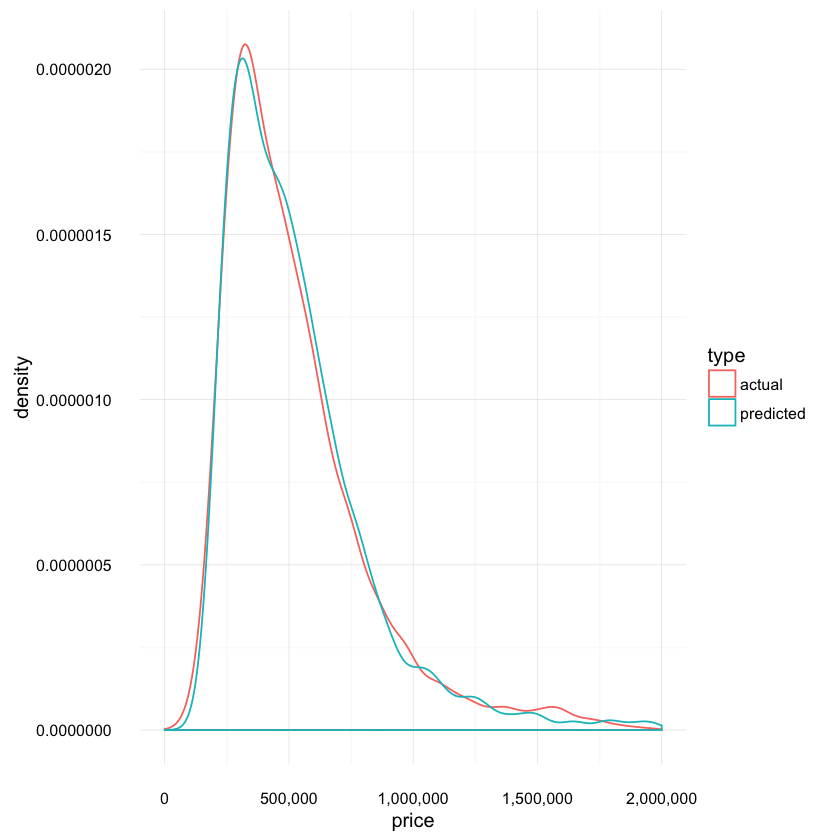

In [35]:
res <- data.frame(price=c(xgb_predicted, test_labels), 
                  type=c(replicate(length(xgb_predicted), "predicted"), replicate(length(test_labels), "actual")))

ggplot(res, aes(x=price, colour=type)) +
    scale_x_continuous(labels = comma, limits = c(0, 2e+06)) +
    scale_y_continuous(labels = comma) +
    geom_density()

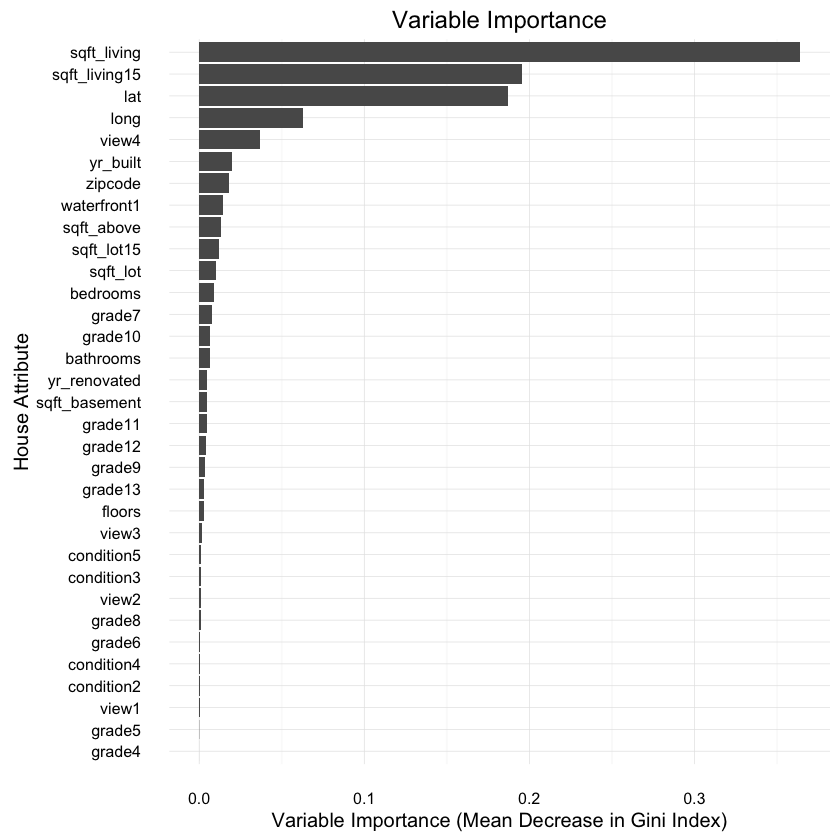

In [36]:
imp <- varImp(trf, scale = FALSE)

imp_names = rev(rownames(imp$importance))
imp_vals = rev(imp$importance[, 1])

var_importance <- data_frame(variable=imp_names,
                             importance=imp_vals)
var_importance <- arrange(var_importance, importance)
var_importance$variable <- factor(var_importance$variable, levels=var_importance$variable)

ggplot(var_importance, aes(x=variable, weight=importance)) +
 geom_bar(position="dodge") + ggtitle("Variable Importance") + coord_flip() +
 xlab("House Attribute") + ylab("Variable Importance (Mean Decrease in Gini Index)") +
 theme(legend.position="none")

# Step 5: Compare distributions of predictions

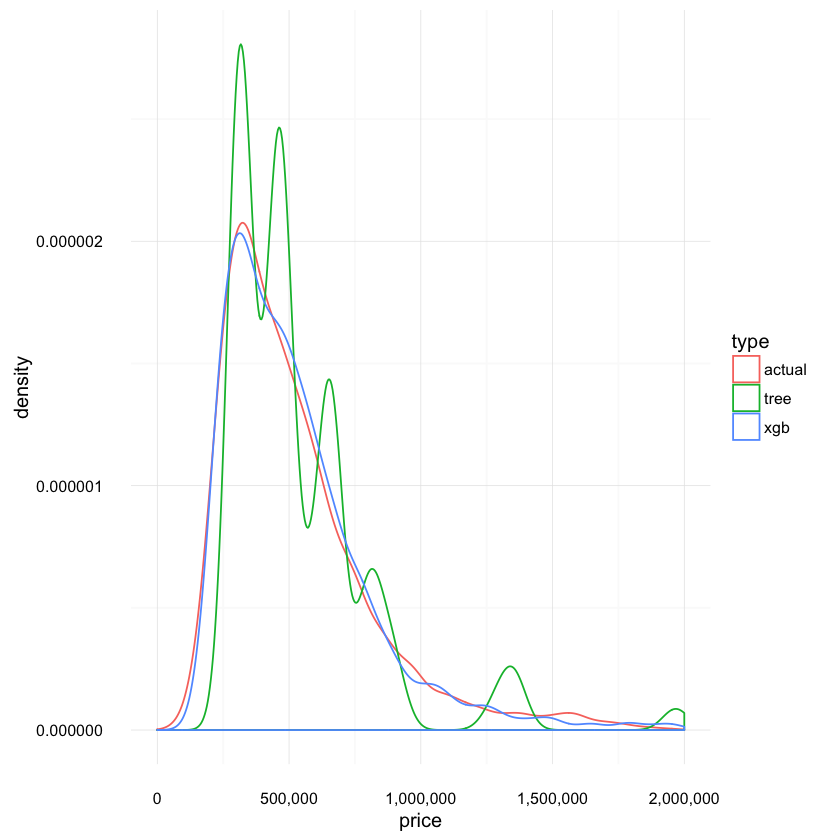

In [37]:
res <- data.frame(price=c(tree_predicted, xgb_predicted, test_labels), 
                  type=c(replicate(length(tree_predicted), "tree"), 
                         replicate(length(xgb_predicted), "xgb"),
                         replicate(length(test_labels), "actual")
                        ))

ggplot(res, aes(x=price, colour=type)) +
    scale_x_continuous(labels = comma, limits = c(0,2e+06)) +
    scale_y_continuous(labels = comma) +
    geom_density()

# Step 6: How well we did?

In [38]:
test_sample <- sample_n(test, 10, replace=FALSE)
test_sample

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10370,680000,2,1.00,2140,6000,1,0,0,4,7,1070,1070,1946,0,98199,47.6510,-122.399,1560,6000
11999,1400000,5,3.00,3850,14990,1,0,0,4,9,2290,1560,1964,0,98004,47.6425,-122.218,3010,15001
10756,400000,3,1.50,1510,8360,1,0,0,3,7,1120,390,1960,0,98007,47.6119,-122.133,1700,8360
16732,468000,3,1.50,1370,7697,1,0,0,3,7,1370,0,1939,0,98177,47.7153,-122.361,1370,7697
17534,220000,3,1.50,1660,15600,2,0,0,3,7,1660,0,1981,0,98001,47.2589,-122.279,1660,14400
3213,525000,4,2.75,2470,7200,1,0,0,5,7,1350,1120,1940,0,98108,47.5631,-122.317,1500,6000
4829,404000,4,3.00,4060,35621,1,0,0,3,9,2030,2030,1989,0,98092,47.3059,-122.108,2950,35259
855,327000,5,2.75,2400,8050,2,0,0,3,8,2400,0,1998,0,98092,47.2635,-122.209,2400,8050
18847,475000,4,2.50,2040,16200,2,0,0,3,8,2040,0,1997,0,98019,47.7366,-121.958,2530,15389
11393,443000,4,1.50,1860,12197,1,0,0,3,7,1860,0,1964,0,98034,47.7290,-122.235,1510,11761


In [39]:
test_predictions <- predict(trf, test_sample, "raw")
test_predictions

[1]  566725.9 1502961.0  465854.2  382869.9  208510.3  553434.1  559598.9
 [8]  316225.9  460287.5  431310.2

In [40]:
actual_prices <- round(test_sample$price, 0)

In [41]:
predicted_prices <- round(test_predictions, 0)

In [42]:
data.frame(actual=actual_prices, predicted=predicted_prices, difference=actual_prices-predicted_prices)

actual,predicted,difference
680000,566726,113274
1400000,1502961,-102961
400000,465854,-65854
468000,382870,85130
220000,208510,11490
525000,553434,-28434
404000,559599,-155599
327000,316226,10774
475000,460288,14712
443000,431310,11690


Is this good?